In [1]:
#set adequate flag for Theano on lxplus
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


Welcome to JupyROOT 6.07/07


In [3]:
#format the inputs from TTree
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is props value (pt, charge, pdgId, etc.)
def formatInputs(files):
    quark_jets = []#type 1
    gluon_jets = []#type 0

    for ifile in files:
        tree = ifile.Get('JetImage')
            
        for ievt, evt in enumerate(tree):            
            #get PFJets
            nPFJets = evt.PFJetEta.size()
            for iPFJet in range(nPFJets):
                pfJetDistance = evt.PFJetDistance[iPFJet]
                pfjet = []
                pt  = []
                eta = []
                phi = []
                e = []
                charge = []
                pdgId = []
                    
                #get daughters
                nDaughters = evt.SubJetEta[iPFJet].size()
                for iDau in range(nDaughters):
                    pt.append( evt.SubJetPt[iPFJet][iDau] )
                    eta.append( evt.SubJetEta[iPFJet][iDau] )
                    phi.append( evt.SubJetPhi[iPFJet][iDau] )
                    e.append( evt.SubJetE[iPFJet][iDau] )
                    charge.append( evt.SubJetCharge[iPFJet][iDau] )
                    pdgId.append( evt.SubJetPDGID[iPFJet][iDau] )
                
                #creates the vector of pfjets properties
                pfjet.append(pfJetDistance)
                pfjet.append(pt)
                pfjet.append(eta)
                pfjet.append(phi)
                pfjet.append(e)
                pfjet.append(charge)
                pfjet.append(pdgId)
                
                #decides if quark or gluon jet
                if evt.PFJetType[iPFJet] == 1:
                    quark_jets.append(pfjet)
                if evt.PFJetType[iPFJet] == 0:
                    gluon_jets.append(pfjet)
                    
    return quark_jets, gluon_jets

In [4]:
#loads input data
vbf_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
ggh_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
inputs = [vbf_inputs,ggh_inputs]

#format tree inputs to adequate shape
quark_jets, gluon_jets = formatInputs(inputs)
print 'quark jets: %i' % len(quark_jets)
print 'gluon jets: %i' % len(gluon_jets)

quark jets: 132654
gluon jets: 16188


In [5]:
#filter events based on DR(eta,phi)
maxDr = 0.4 #jet radius - ak4PFJetCHS
fquark_jets = []
fgluon_jets = []

for ijet in quark_jets:
    if(ijet[0] < maxDr):
        fquark_jets.append([ijet[1],ijet[2],ijet[3],ijet[4],ijet[5]])
        
for ijet in gluon_jets:
    if(ijet[0] < maxDr):
        fgluon_jets.append([ijet[1],ijet[2],ijet[3],ijet[4],ijet[5]])
        
maxjets = min(len(fquark_jets),len(fgluon_jets))
fquark_jets = [fquark_jets[i] for i in range(maxjets)]
fgluon_jets = [fgluon_jets[i] for i in range(maxjets)]
print 'quark jets: %i (%.2f)' % (len(fquark_jets),len(fquark_jets)/float(len(quark_jets)))
print 'gluon jets: %i (%.2f)' % (len(fgluon_jets),len(fgluon_jets)/float(len(gluon_jets)))

quark jets: 8370 (0.06)
gluon jets: 8370 (0.52)


In [6]:
from keras.layers import LSTM, Bidirectional, Masking
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Bidirectional LSTM Model
def build_bilstm_model(n_cand_per_jet, features_per_jet):
    # Headline input: meant to receive sequences of 200 floats
    # Note that we can name any layer by passing it a "name" argument.
    i = Input(shape=(n_cand_per_jet, features_per_jet,), name='main_input')
    # the masking layer will prevent the LSTM layer to consider the 0-padded jet values
    m = Masking()(i)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    # the Bidirectional will make the LSTM cell read the sequence from end to start and start to end at the same time
    m = Bidirectional( LSTM(25) ) (m)
    
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(m)
    model = Model(input=[i], output=[auxiliary_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
njets = 8000
n_cand_per_jet = 100
features = {
    'ak4pfcand_pt' : None,
    'ak4pfcand_eta' : None
    #'ak4pfcand_phi' : None,
    #'ak4pfcand_e' : None,
    #'ak4pfcand_charge' : None
}
features_per_jet = len(features)
model = build_bilstm_model(n_cand_per_jet, features_per_jet)
print model.summary()

momentum_input = {}
momentum_input['quark'] = np.zeros((njets, n_cand_per_jet, features_per_jet)) # 3 momentum
momentum_input['gluon'] = np.zeros((njets, n_cand_per_jet, features_per_jet)) # 3 momentum

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100, 2)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 100, 2)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                5600      
_________________________________________________________________
aux_output (Dense)           (None, 1)                 51        
Total params: 5,651
Trainable params: 5,651
Non-trainable params: 0
_________________________________________________________________
None


/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[sigmoid.0..., inputs=[/main_inp...)`


In [8]:
for pfj in range(njets):
    for sbj in range(n_cand_per_jet):
        for prop in range(len(features)):
            if(sbj < len(fquark_jets[pfj][prop])):
                momentum_input['quark'][pfj][sbj][prop] = fquark_jets[pfj][prop][sbj]
            if(sbj < len(fgluon_jets[pfj][prop])):
                momentum_input['gluon'][pfj][sbj][prop] = fgluon_jets[pfj][prop][sbj]

#print momentum_input['VBF']
#print momentum_input['GGH']

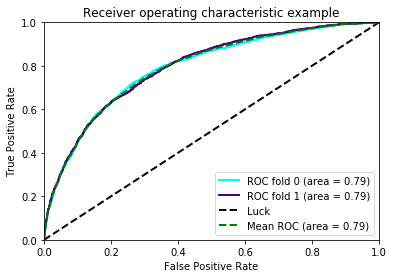

		Fold 0
Train on 8000 samples, validate on 8000 samples
Epoch 1/30
8000/8000 [==============================] - 35s - loss: 0.6227 - acc: 0.6699 - val_loss: 0.5915 - val_acc: 0.6900
Epoch 2/30
8000/8000 [==============================] - 36s - loss: 0.5750 - acc: 0.7045 - val_loss: 0.5746 - val_acc: 0.7031
Epoch 3/30
8000/8000 [==============================] - 35s - loss: 0.5645 - acc: 0.7110 - val_loss: 0.5676 - val_acc: 0.7109
Epoch 4/30
8000/8000 [==============================] - 35s - loss: 0.5599 - acc: 0.7163 - val_loss: 0.5644 - val_acc: 0.7169
Epoch 5/30
8000/8000 [==============================] - 36s - loss: 0.5562 - acc: 0.7165 - val_loss: 0.5622 - val_acc: 0.7210
Epoch 6/30
8000/8000 [==============================] - 36s - loss: 0.5542 - acc: 0.7206 - val_loss: 0.5616 - val_acc: 0.7196
Epoch 7/30
8000/8000 [==============================] - 36s - loss: 0.5523 - acc: 0.7214 - val_loss: 0.5610 - val_acc: 0.7183
Epoch 8/30
8000/8000 [==============================] - 35s -

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[sigmoid.0..., inputs=[/main_inp...)`
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [9]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

X = np.concatenate([momentum_input['quark'], momentum_input['gluon']])
Y_TT = np.ones(momentum_input['quark'].shape[0])
Y_QCD = np.zeros(momentum_input['gluon'].shape[0])
Y = np.concatenate([Y_TT, Y_QCD])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for i,((train, test), color) in enumerate(zip(kfold.split(X, encoded_Y), colors)):
    print "\t\tFold",i
    bilstm_model = build_bilstm_model(n_cand_per_jet, features_per_jet)
    history = bilstm_model.fit(X[train], encoded_Y[train], 
                               validation_data=(X[test], encoded_Y[test]), 
                               nb_epoch=30, batch_size=128, 
                               verbose=1, callbacks=[early_stopping])
    Y_score = bilstm_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()